In [7]:
import numpy as np, os, h5py, pandas as pd
np.set_printoptions(suppress=True)
import tensorflow as tf
from tensorflow import keras as tfk
from tfomics import tfomics 
from tfomics.tfomics import moana, impress, explain
import logomaker
from logomaker import Logo

from paramiko import SSHClient
from scp import SCPClient

from pairwise_conv_1d import PairwiseConv1D, PairwiseFromStdConv1D
from nearest_neighbor_conv_1d import NearestNeighborConv1D, NearestNeighborFromStdConv1D
from ho_regularizer import HigherOrderKernelRegularizer

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
%load_ext autoreload
%autoreload 2
tfk.backend.clear_session()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Get data 

In [8]:
reverse_compliment = True
data_path = os.path.join('./../../../genomics_datasets/exponential_activations')
filepath = os.path.join(data_path, 'IRF1_400_h3k27ac.h5')
with h5py.File(filepath, 'r') as dataset:
    x_train = np.array(dataset['X_train']).astype(np.float32)
    y_train = np.array(dataset['Y_train']).astype(np.float32)
    x_valid = np.array(dataset['X_valid']).astype(np.float32)
    y_valid = np.array(dataset['Y_valid']).astype(np.int32)
    x_test = np.array(dataset['X_test']).astype(np.float32)
    y_test = np.array(dataset['Y_test']).astype(np.int32)

x_train = np.squeeze(x_train).transpose([0,2,1])
x_valid = np.squeeze(x_valid).transpose([0,2,1])
x_test = np.squeeze(x_test).transpose([0,2,1])
n = x_train.shape[0]

if reverse_compliment:
    x_train_rc = x_train[:,::-1,:][:,:,::-1]
    x_valid_rc = x_valid[:,::-1,:][:,:,::-1]
    x_test_rc = x_test[:,::-1,:][:,:,::-1]

    x_train = np.vstack([x_train, x_train_rc])
    x_valid = np.vstack([x_valid, x_valid_rc])
    x_test = np.vstack([x_test, x_test_rc])

    y_train = np.vstack([y_train, y_train])
    y_valid = np.vstack([y_valid, y_valid])
    y_test = np.vstack([y_test, y_test])

# create tensorflow dataset
trainset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
sampleset = tf.data.Dataset.from_tensor_slices((x_valid[:2], y_valid[:2]))

N, L, A = x_test.shape
num_labels = y_test.shape[1]

OSError: Unable to open file (unable to open file: name = './../../../genomics_datasets/exponential_activations/IRF1_400_h3k27ac.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [3]:
def get_model(input_shape, first_layer_conv, name='model', first_layer_activation='relu'):
    x = tfk.layers.Input(shape=input_shape, name='input')
    y = first_layer_conv(x)
    if first_layer_conv.use_bias:
        y = tfk.layers.BatchNormalization()(y)
    y = tfk.layers.Activation(first_layer_activation, name=first_layer_activation)(y)
    y = tfk.layers.MaxPool1D(pool_size=25)(y)
    y = tfk.layers.Dropout(0.1)(y)
    
    # layer 2 - convolution
    l2 = tfk.regularizers.l2(1e-4)
    y = tfk.layers.Conv1D(filters=48,kernel_size=7,strides=1,padding='same',kernel_regularizer=l2, )(y)        
    y = tfk.layers.Activation('relu')(y)
    y = tfk.layers.MaxPool1D(pool_size=4)(y)
    y = tfk.layers.Dropout(0.1)(y)

    # layer 3 - Fully-connected 
    y = tfk.layers.Flatten()(y)
    y = tfk.layers.Dense(96,use_bias=False,kernel_regularizer=l2)(y)      
    y = tfk.layers.BatchNormalization()(y)
    y = tfk.layers.Activation('relu')(y)
    y = tfk.layers.Dropout(0.5)(y)

    # Output layer
    y = tfk.layers.Dense(1, kernel_initializer='glorot_normal',name='logits')(y)
    y = tfk.layers.Activation('sigmoid')(y)

    # create keras model
    model = tfk.Model(inputs=x, outputs=y, name=name)
    
    return model

## Standard convolution as first layer 

In [6]:
# instantiate model 
input_shape = x_train.shape[1:]
first_layer_activation = 'exponential'
diag_regularizer = tfk.regularizers.l1_l2(l1=5e-4, l2=5e-4)
conv_kwargs = {'padding':'same', 'use_bias':False, 'filters':32, 'kernel_size':21}
first_layer_conv = tfk.layers.Conv1D(kernel_regularizer=diag_regularizer, **conv_kwargs)
stdmodel = get_model(input_shape, first_layer_conv, first_layer_activation=first_layer_activation, name='std_model')

In [7]:
# compile the model - metrics, optimizer, lossfn 
lossfn = tfk.losses.BinaryCrossentropy(name='BCE')
acc = tfk.metrics.BinaryAccuracy(name='Acc')
auroc = tfk.metrics.AUC(curve='ROC', name='AUROC')
aupr = tfk.metrics.AUC(curve='PR', name='AUPR')
metrics = [acc, auroc, aupr]
optimizer = tfk.optimizers.Adam(learning_rate=1e-3)
stdmodel.compile(optimizer, lossfn, metrics)

In [8]:
# train the model 
load_checkpoint = True
if not load_checkpoint:
    monitor = 'val_AUROC'
    batch_size = 128
    validation_data = (x_valid, y_valid)
    callbacks = [tfk.callbacks.EarlyStopping(monitor=monitor, patience=10, verbose=1, mode='max'),
                tfk.callbacks.ReduceLROnPlateau(monitor=monitor, patience=3, factor=0.2, min_lr=1e-7, mode='max', verbose=1),
                tfk.callbacks.ModelCheckpoint("./%s.hdf5"%stdmodel.name, 
                                              save_best_only=True, save_weights_only=True, monitor=monitor, mode='max')]
    stdmodel.fit(x_train, y_train, validation_data=validation_data, callbacks=callbacks, epochs=40, batch_size=batch_size)
stdmodel.load_weights("%s.hdf5"%stdmodel.name)

## Pairwise model with diagonal transferred from pre-trained diagonal model

In [11]:
stdconv = stdmodel.layers[1]
offdiag_regularizer = tfk.regularizers.l1_l2(l1=5e-2, l2=5e-2)
pconv = PairwiseFromStdConv1D(offdiag_regularizer=offdiag_regularizer, stdconv=stdconv)
p_model_1 = get_model(first_layer_conv=pconv, 
                      first_layer_activation=first_layer_activation, 
                      input_shape=input_shape, 
                      name="p_model_1")

In [12]:
# compile the model - metrics, optimizer, lossfn 
lossfn = tfk.losses.BinaryCrossentropy(name='BCE')
acc = tfk.metrics.BinaryAccuracy(name='Acc')
auroc = tfk.metrics.AUC(curve='ROC', name='AUROC')
aupr = tfk.metrics.AUC(curve='PR', name='AUPR')
metrics = [acc, auroc, aupr]
optimizer = tfk.optimizers.Adam(learning_rate=1e-3)
p_model_1.compile(optimizer, lossfn, metrics)

In [13]:
# train the model 
if not load_checkpoint:
    validation_data = (x_valid, y_valid)
    callbacks = [tfk.callbacks.EarlyStopping(monitor=monitor, patience=10, verbose=1, mode='max'),
                tfk.callbacks.ReduceLROnPlateau(monitor=monitor, patience=3, factor=0.2, min_lr=1e-7, mode='max', verbose=1),
                tfk.callbacks.ModelCheckpoint("./%s.hdf5"%p_model_1.name, 
                                              save_best_only=True, save_weights_only=True, monitor=monitor, mode='max')]


    p_model_1.fit(x_train, y_train, validation_data=validation_data, callbacks=callbacks, epochs=50, batch_size=batch_size)
p_model_1.load_weights("%s.hdf5"%p_model_1.name)

## Pairwise model without pretrained diagonal 

In [17]:
kernel_regularizer = HigherOrderKernelRegularizer(
                                diag_regularizer=diag_regularizer, 
                                offdiag_regularizer=offdiag_regularizer
                                                )
pconv = PairwiseConv1D(kernel_regularizer=kernel_regularizer, **conv_kwargs)
p_model_2 = get_model(first_layer_conv=pconv, 
                      first_layer_activation=first_layer_activation, 
                      input_shape=input_shape, 
                      name="p_model_2") 

In [18]:
# compile the model - metrics, optimizer, lossfn 
lossfn = tfk.losses.BinaryCrossentropy(name='BCE')
acc = tfk.metrics.BinaryAccuracy(name='Acc')
auroc = tfk.metrics.AUC(curve='ROC', name='AUROC')
aupr = tfk.metrics.AUC(curve='PR', name='AUPR')
metrics = [acc, auroc, aupr]
optimizer = tfk.optimizers.Adam(learning_rate=1e-3)
p_model_2.compile(optimizer, lossfn, metrics)

In [19]:
# train the model 
if not load_checkpoint:
    validation_data = (x_valid, y_valid)
    callbacks = [tfk.callbacks.EarlyStopping(monitor=monitor, patience=10, verbose=1, mode='max'),
                tfk.callbacks.ReduceLROnPlateau(monitor=monitor, patience=3, factor=0.2, min_lr=1e-7, mode='max', verbose=1),
                tfk.callbacks.ModelCheckpoint("./%s.hdf5"%p_model_2.name, 
                                              save_best_only=True, save_weights_only=True, monitor=monitor, mode='max')]
    p_model_2.fit(x_train, y_train, validation_data=validation_data, callbacks=callbacks, epochs=40, batch_size=batch_size)
p_model_2.load_weights("%s.hdf5"%p_model_2.name)

## Model performance 

In [20]:
std_metrics = stdmodel.evaluate(x_test, y_test.astype(np.float32), return_dict=False)
p1_metrics = p_model_1.evaluate(x_test, y_test.astype(np.float32), return_dict=False)
p2_metrics = p_model_2.evaluate(x_test, y_test.astype(np.float32), return_dict=False)
data = np.vstack([std_metrics, p1_metrics, p2_metrics])
index=pd.Index(['standard', 'pairwise(transferred)','pairwise'],name='Model')
columns = stdmodel.metrics_names
pd.DataFrame(data=data[:, -3:], 
             index=index,
             columns=columns[-3:],
             )

49/49 [==============================] - 3s 57ms/step - loss: 0.2514 - Acc: 0.9323 - AUROC: 0.9839 - AUPR: 0.9835


,Acc,AUROC,AUPR
Model,,,
standard,0.926187,0.980872,0.978891
pairwise(transferred),0.908858,0.982501,0.978835
pairwise,0.930039,0.978326,0.976531


## Filter visualization

In [21]:
def visualize_filters(W, num_rows, num_cols, alphabet='ACGT', title=""):
    n_filters, filter_len = W.shape[:2]
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(3*num_cols, 1.2*num_rows))
    
    for i, w in enumerate(W):
        ax[int(i/num_cols), i%num_cols].set_xticks([])
        ax[int(i/num_cols), i%num_cols].set_yticks([])
        I = np.log2(4) + np.sum(w * np.log2(w+1e-7), axis=1, keepdims=True)
        logo = logo = I*w
        logo = Logo(
            pd.DataFrame(data=logo, columns=list(alphabet), index=list(range(filter_len))), 
            ax=ax[int(i/num_cols), i%num_cols]
                    )
        ax[int(i/num_cols), i%num_cols].set_ylabel(i)
        ax[int(i/num_cols), i%num_cols].set_ylim(0, 2)
    fig.suptitle(title, fontsize=15)
    fig.tight_layout()

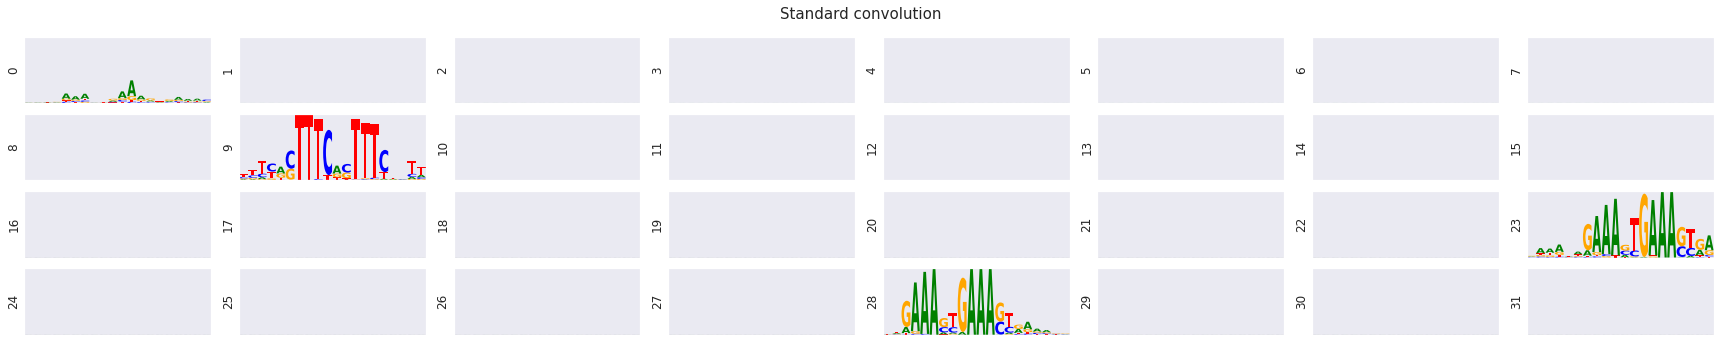

In [22]:
idx = np.random.randint(0, x_test.shape[0], (500,))
threshold = 0.5
num_rows, num_cols = 4, 8
for i, ell in enumerate(stdmodel.layers):
    if ell == stdmodel.get_layer(first_layer_activation):
        layer = i
        break

W_std = moana.filter_activations(x_test[idx], stdmodel, layer=layer, window=20, threshold=threshold)
#W_std = tf.transpose(stdmodel.layers[1].kernel, (2, 0, ))
visualize_filters(W_std, num_rows, num_cols, title="Standard convolution")

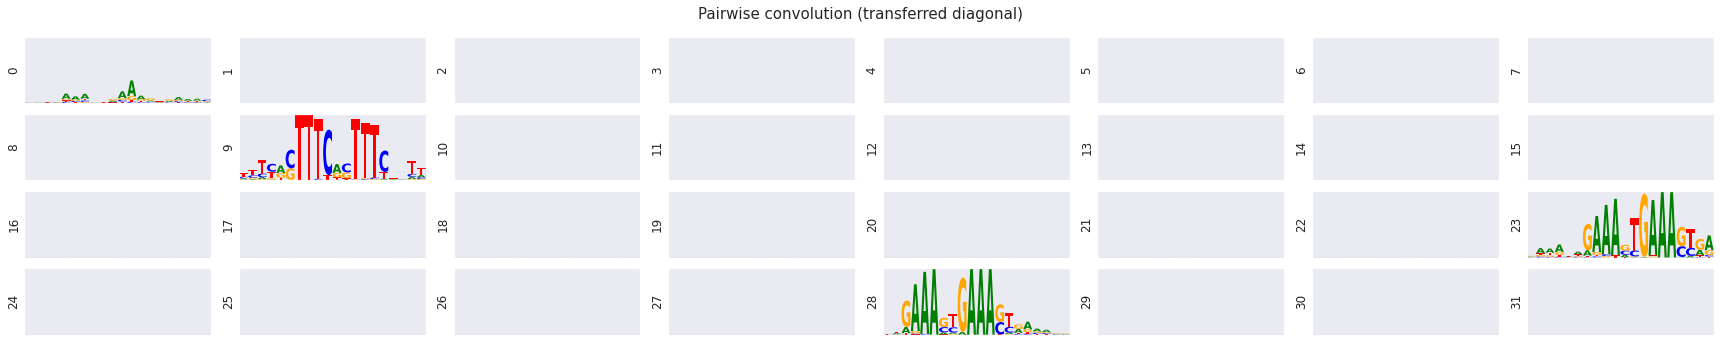

In [23]:
W_p1 = moana.filter_activations(x_test[idx], p_model_1, layer=layer, window=20, threshold=threshold)
visualize_filters(W_p1, num_rows, num_cols, title="Pairwise convolution (transferred diagonal)")

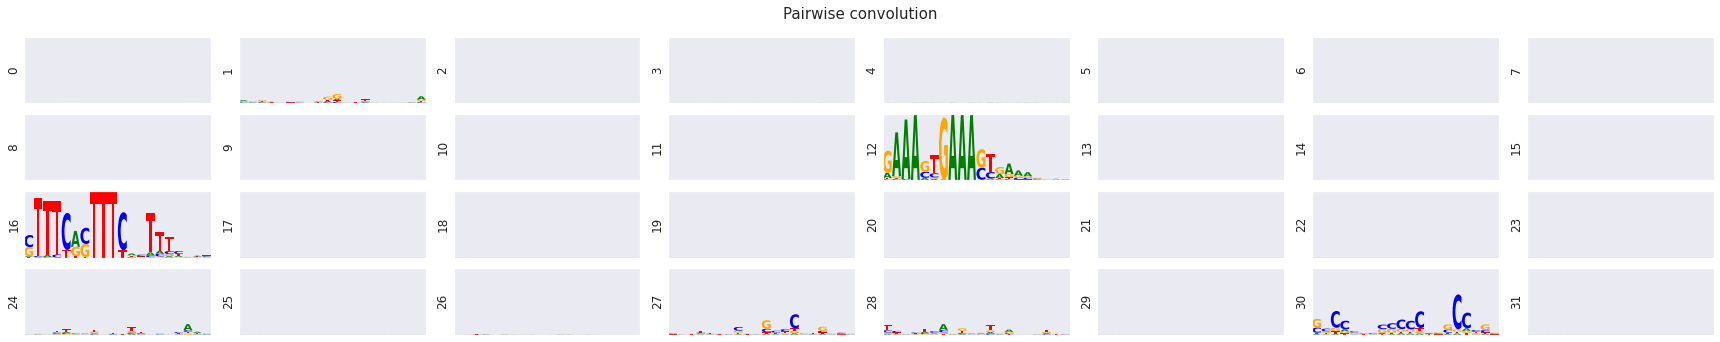

In [24]:
W_p2 = moana.filter_activations(x_test[idx], p_model_2, layer=layer, window=20, threshold=threshold)
visualize_filters(W_p2, num_rows, num_cols, title="Pairwise convolution")

## Model explanation

In [31]:
X = x_test[np.where(y_test == 1.)[0]][:500]
std_explainer = explain.Explainer(model=stdmodel, class_index=0)
p1_explainer = explain.Explainer(model=p_model_1, class_index=0)
p2_explainer = explain.Explainer(model=p_model_2, class_index=0)

In [33]:
print("Get saliency scores...")
std_saliency = std_explainer.saliency_maps(X)
p1_saliency = p1_explainer.saliency_maps(X)
p2_saliency = p2_explainer.saliency_maps(X)

# print("Get integrated gradient scores...")
# std_ig = std_explainer.integrated_grad(X)
# p1_ig = p1_explainer.integrated_grad(X)
# p2_ig = p2_explainer.integrated_grad(X)

# print("Get smoothgrad scores...")
# std_sg = std_explainer.smoothgrad(X)
# p1_sg = p1_explainer.smoothgrad(X)
# p2_sg = p2_explainer.smoothgrad(X)

Get saliency scores...


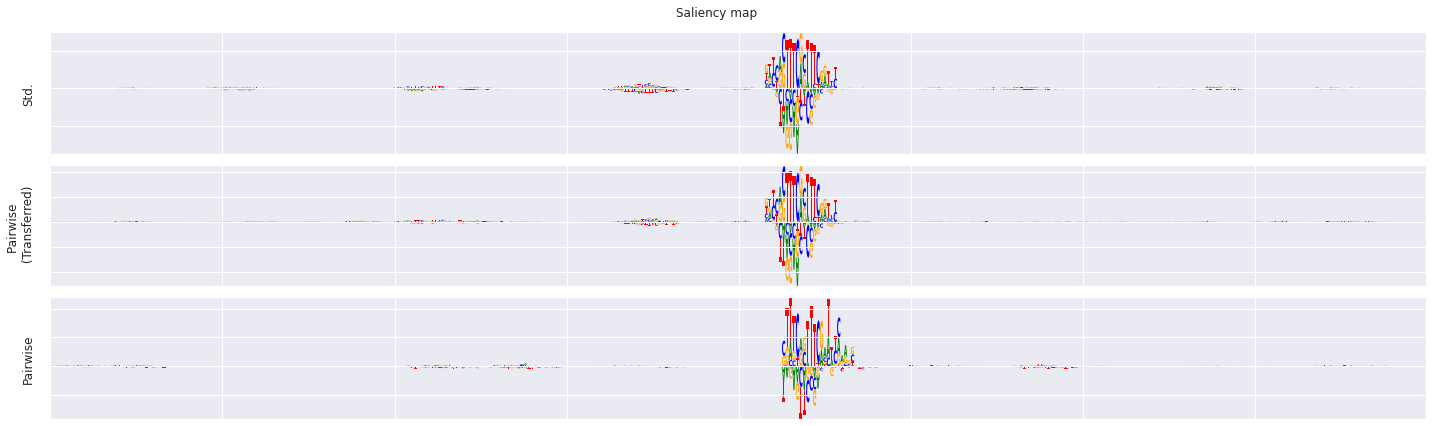

In [36]:
idx = np.random.randint(0, len(X)) # pick a random example

fig, ax = plt.subplots(3, 1, figsize=(20, 6))
for i in range(len(ax)):
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])

ax[0].set_ylabel("Std.")
ax[1].set_ylabel("Pairwise \n (Transferred)")
ax[2].set_ylabel("Pairwise")

Logo(
    df=pd.DataFrame(std_saliency[idx], columns=list('ACGT')),
    ax=ax[0]
    )
Logo(
    df=pd.DataFrame(p1_saliency[idx], columns=list('ACGT')),
    ax=ax[1]
    )
Logo(
    df=pd.DataFrame(p2_saliency[idx], columns=list('ACGT')),
    ax=ax[2]
    )

fig.suptitle('Saliency map')
fig.tight_layout()

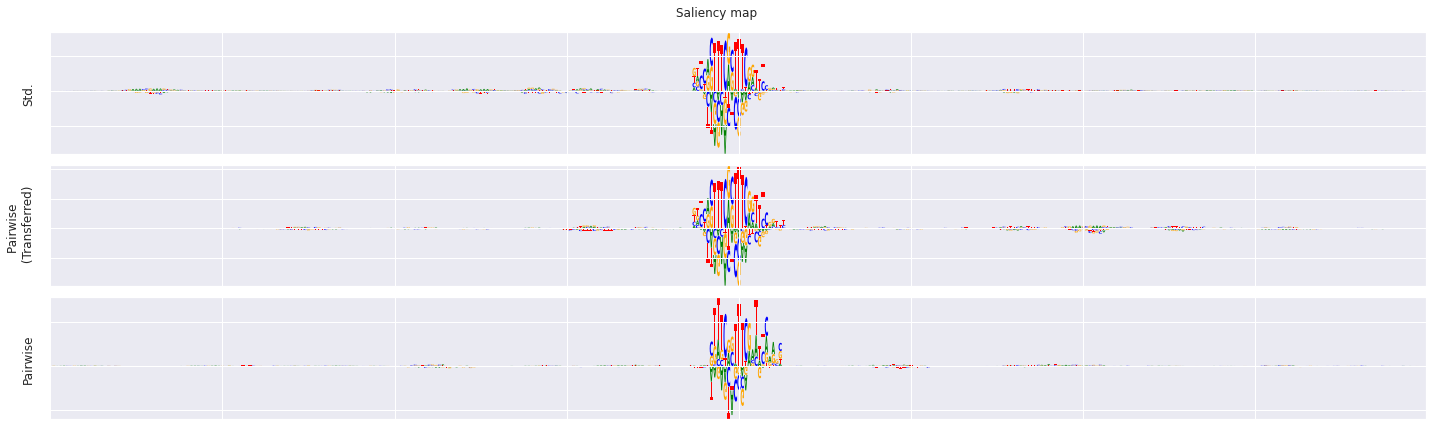

In [37]:
idx = np.random.randint(0, len(X)) # pick a random example

fig, ax = plt.subplots(3, 1, figsize=(20, 6))
for i in range(len(ax)):
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])

ax[0].set_ylabel("Std.")
ax[1].set_ylabel("Pairwise \n (Transferred)")
ax[2].set_ylabel("Pairwise")

Logo(
    df=pd.DataFrame(std_saliency[idx], columns=list('ACGT')),
    ax=ax[0]
    )
Logo(
    df=pd.DataFrame(p1_saliency[idx], columns=list('ACGT')),
    ax=ax[1]
    )
Logo(
    df=pd.DataFrame(p2_saliency[idx], columns=list('ACGT')),
    ax=ax[2]
    )

fig.suptitle('Saliency map')
fig.tight_layout()

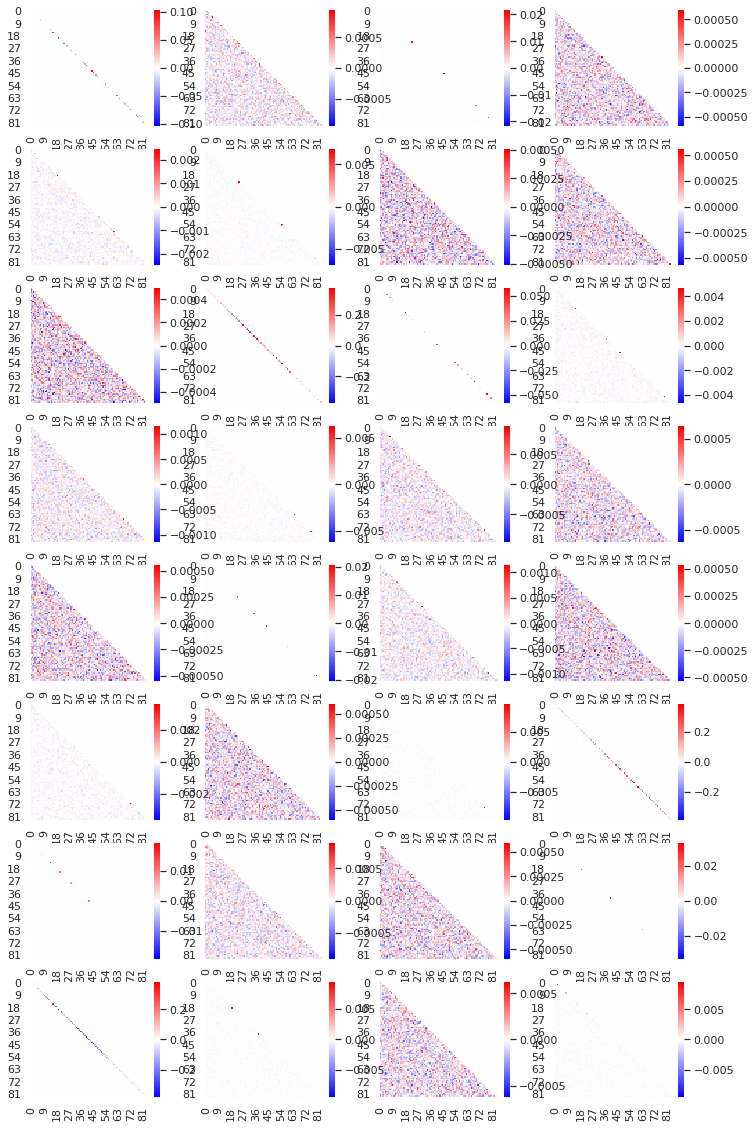

In [80]:
kernel_size = p_model_1.layers[1].kernel_size[0]
p1kern = tf.transpose(p_model_1.layers[1].kernel, (2, 0, 1)).numpy()

fig, ax = plt.subplots(8, 4, figsize=(12, 20))

for row in range(8):
    for col in range(4):
        index = row*4 + col
        w = p1kern[index]
        VAL = np.maximum(np.abs(np.min(w)), np.max(w))
        sns.heatmap(w, cmap='bwr', vmin=-VAL, vmax=VAL, ax=ax[row, col])    

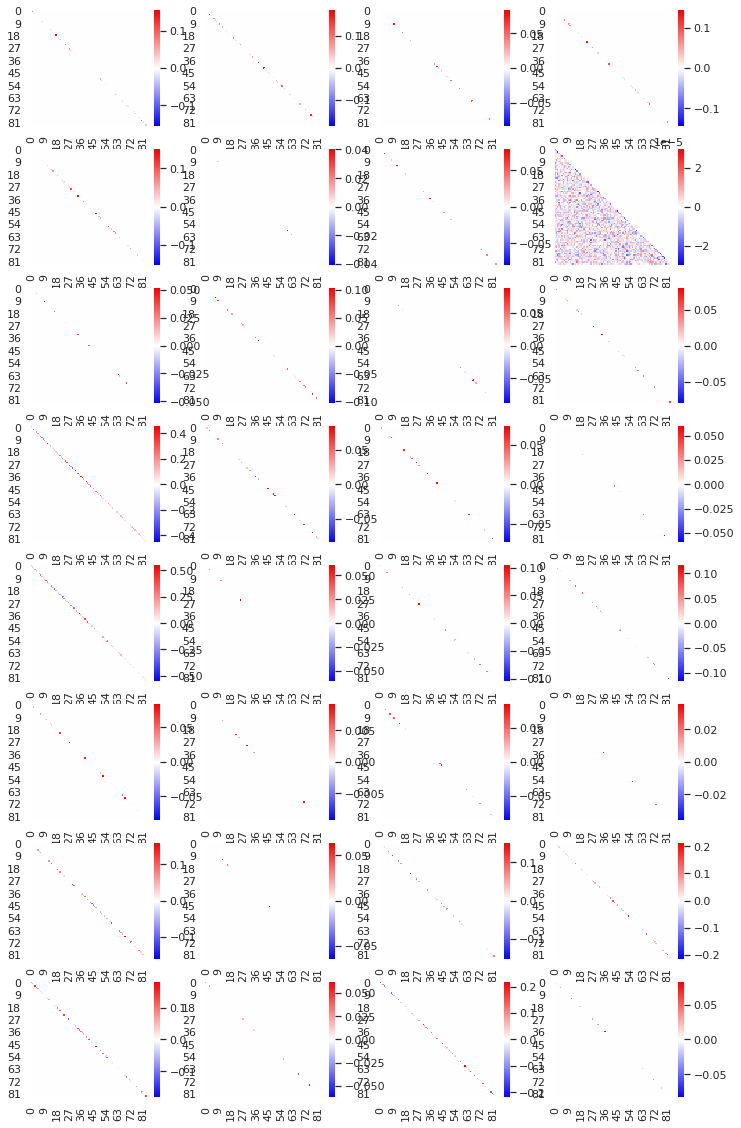

In [82]:
kernel_size = p_model_2.layers[1].kernel_size[0]
p2kern = tf.transpose(p_model_2.layers[1].kernel, (2, 0, 1)).numpy()

fig, ax = plt.subplots(8, 4, figsize=(12, 20))

for row in range(8):
    for col in range(4):
        index = row*4 + col
        w = p2kern[index]
        VAL = np.maximum(np.abs(np.min(w)), np.max(w))
        sns.heatmap(w, cmap='bwr', vmin=-VAL, vmax=VAL, ax=ax[row, col])

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(20, 6))
for i in range(len(ax)):
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])

ax[0].set_ylabel("Std.")
ax[1].set_ylabel("Pairwise \n (Transferred)")
ax[2].set_ylabel("Pairwise")

Logo(
    df=pd.DataFrame(std_ig[idx], columns=list('ACGT')),
    ax=ax[0]
    )
Logo(
    df=pd.DataFrame(p1_ig[idx], columns=list('ACGT')),
    ax=ax[1]
    )
Logo(
    df=pd.DataFrame(p2_ig[idx], columns=list('ACGT')),
    ax=ax[2]
    )

fig.suptitle('Integrated gradients')
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(20, 6))
for i in range(len(ax)):
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])

ax[0].set_ylabel("Std.")
ax[1].set_ylabel("Pairwise \n (Transferred)")
ax[2].set_ylabel("Pairwise")

Logo(
    df=pd.DataFrame(std_sg[idx], columns=list('ACGT')),
    ax=ax[0]
    )
Logo(
    df=pd.DataFrame(p1_sg[idx], columns=list('ACGT')),
    ax=ax[1]
    )
Logo(
    df=pd.DataFrame(p2_sg[idx], columns=list('ACGT')),
    ax=ax[2]
    )

fig.suptitle('Smoothgrad')
fig.tight_layout()

## Pairwise information visualization

In [ ]:
W1 = tf.transpose(p_model_1.layers[1].kernel, (2, 0, 1)).numpy()
W2 = tf.transpose(p_model_2.layers[1].kernel, (2, 0, 1)).numpy()

In [ ]:
kernel_size = conv_kwargs['kernel_size']
num_channels = int(pconv.diag_kernel.shape[0]/kernel_size)
mask = np.zeros_like(W1[0])
mask[np.tril_indices(W1[0].shape[0])] = 1
mask = ~mask.astype(bool)

In [ ]:
VAL = np
fig, ax = plt.subplots(1, 1, figsize=(0.4*kernel_size, 0.3*kernel_size))
sns.heatmap(W1[0], linewidth=0.05, mask=mask, cmap='bwr')
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(0.4*kernel_size, 0.3*kernel_size))
sns.heatmap(W2[4], linewidth=0.05, mask=mask, cmap='bwr')
fig.tight_layout()

In [ ]:
W1diag = p_model_1.layers[1].diag_kernel
W1offdiag = p_model_1.layers[1].offdiag_kernel
plt.figure(figsize=(8, 5))

h2=plt.hist(W1offdiag.numpy().flatten(), linewidth=0., label='offdiag', density=True, bins=200);
#h1=plt.hist(W1diag.numpy().flatten(), linewidth=0., label='diag', density=True, bins=100);
plt.legend(loc='best')
#plt.ylim([0, 20])

In [ ]:
idx=np.where(h2[1] >= 0)[0][0]
print(h2[0][idx-1:idx+1])

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()
h1 = ax.hist(W1offdiag.numpy().flatten(), linewidth=0., 
             alpha=0.75, label='offdiag', density=True, bins=200);
#ax.set_xlim([-0.001, 0.001])
ax.legend(loc='upper left', fontsize=15)

ax2=ax.twinx()
ax2.hist(W1diag.numpy().flatten(), linewidth=0., 
         label='diag', density=True, bins=200, color='r', alpha=0.5);
ax2.legend(loc='upper right', fontsize=15)

fig.tight_layout()

In [ ]:
std